In [1]:
# Edgar new data Jan 2024

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pathlib
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *

seed = 2468
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

NVIDIA GeForce GTX TITAN X


In [2]:
'''
The imaging is still at 30hz.
The ephys is binarized in 1ms bins.
The speed has corresponding triggers in imaging and ephys.
I.e. for every entry in the speed file, there is a corresponding imaging frame or ephys bin at the given index.
There are files for baseline and for stimulation. In each case, the imaging ROIs and the ephys units are matched.
I.e. index 1 in baseline imaging is the same cell as index 1 is stim imaging.

Please see if this format works for you. Let me know if you want me to downsample all of them to the same frame rate (30Hz) instead if that is easier for you. If this runs ok, then I can run another 1-2 mice through which should put us at 3-4 animals. I will work on getting the combinatorial paradigm in place as well, but it is a little bit complicated right now.
'''
parent_path = Path('./data/biological/EB095/')
stim_path = parent_path / "EB095_stim/"
run_path = parent_path / "EB095_run/"


area_ID_ephys = np.load(run_path / 'area_ID_ephys.npy')        # (106,) 8 LS, 70 ACC
dff_run = np.load(run_path / 'dff_run.npy')                    # (294, 32727) GCaMP when running
dff_stim = np.load(stim_path /'dff_stim.npy')                  # (294, 94696) GCaMP when stimulated 
spks_run = np.load(run_path / 'spks_run.npy')                  # (106, 32727)
spks_stim = np.load(stim_path /'spks_stim.npy')                # (106, 94096)
speed_run = np.load(run_path / 'speed_run.npy')                # (32727,) max 13

# speed_triggers_ephys_run = np.load(run_path / 'speed_triggers_ephys_run.npy')  # (56322)
# speed_triggers_img_run = np.load(run_path / 'speed_triggers_img_run.npy')      # (56322)
stim_ID = np.load(stim_path /'stim_ID.npy')
stim_ID_resolved = np.load(stim_path /'stim_ID_resolved.npy')  # (300, 6), R S or F
stim_time = np.load(stim_path /'stim_triggers.npy')            # (300, )

Exploratory analysis: Running vs Activity

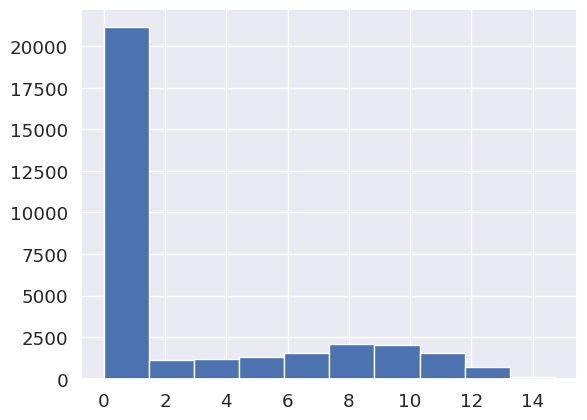

In [3]:
# (106, 56322)
plt.hist(speed_run) # (56302)
plt.show()

Naive model fitting:
Ignore running / stationary, fit model to both data.

### Convolve spikes

In [4]:
spks_stim_rates = rbf_rate_convolution_2d(spks_stim.T, sigma=0.1) # [93996, 106]
n_output_neurons, n_bins = spks_stim.shape
n_input_neurons = dff_stim.shape[0]
spks_stim_rates = torch.hstack([torch.zeros((n_output_neurons, 50)), spks_stim_rates, torch.zeros((n_output_neurons, 50))])

assert np.array(spks_stim_rates.shape).all() == np.array(spks_stim.shape).all()

spks_stim_rates = spks_stim_rates.T

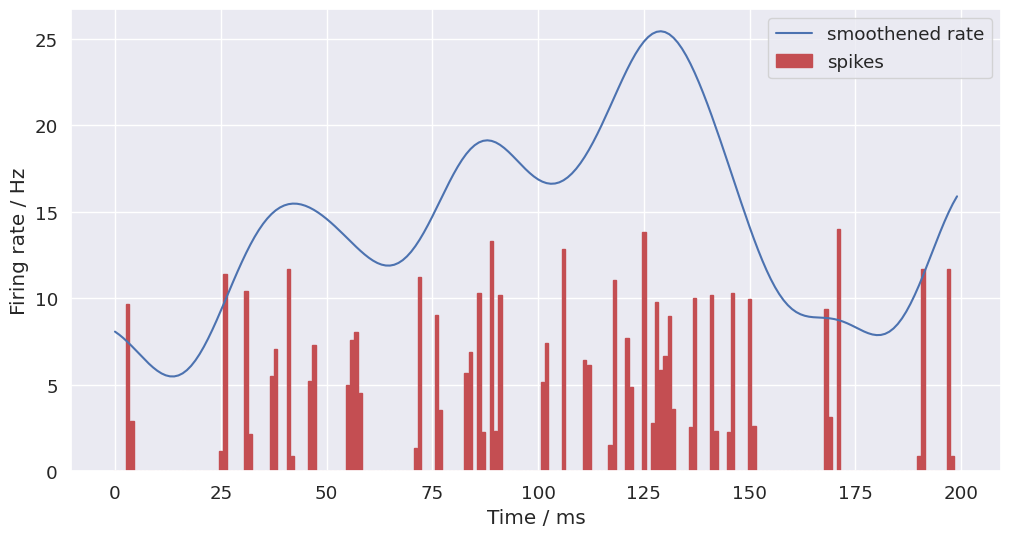

In [5]:
# visualise a sample of ephys smooth rates
_range = 200
_random_start = np.random.randint(0, n_bins-_range)
_random_neuron_idx = np.random.randint(0, n_output_neurons)

plt.figure(figsize=(12,6))
plt.plot(spks_stim_rates[_random_start:_random_start+_range, _random_neuron_idx], label='smoothened rate')
plt.bar(np.arange(200), height = spks_stim[_random_neuron_idx, _random_start:_random_start+_range] * spks_stim_rates[_random_start:_random_start+_range, _random_neuron_idx].mean().numpy(), color='r', edgecolor='r', label='spikes')
plt.ylabel('Firing rate / Hz')
plt.xlabel('Time / ms')
plt.legend()
plt.show()

# 10 time steps = 1 sigma = 330 ms

Average firing rates of each neuron

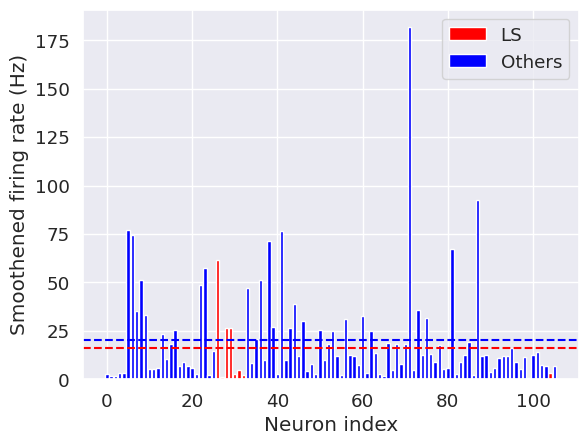

LS neuron firing rate: 16.095746994018555 Hz
non-LS neuron firing rate: 20.01192283630371 Hz


In [10]:
mask1 = area_ID_ephys == 'LS'
mask2 = area_ID_ephys != 'LS'

plt.bar(np.arange(spks_stim_rates.shape[1])[mask1], spks_stim_rates.mean(0)[mask1], color='red', label='LS')
plt.bar(np.arange(spks_stim_rates.shape[1])[mask2], spks_stim_rates.mean(0)[mask2], color='blue', label='Others')
plt.axhline(spks_stim_rates.mean(0)[mask1].mean(), linestyle='--', color='red')
plt.axhline(spks_stim_rates.mean(0)[mask2].mean(), linestyle='--', color='blue')
plt.legend()
plt.xlabel('Neuron index')
plt.ylabel('Smoothened firing rate (Hz)')
plt.show()
print(f'LS neuron firing rate: {spks_stim_rates.mean(0)[mask1].mean()} Hz')
print(f'non-LS neuron firing rate: {spks_stim_rates.mean(0)[mask2].mean()} Hz')

### Data Pre-processing

In [18]:
tsteps = 15
cutoff_size = 2

dff_stim = dff_stim.T

assert dff_stim.shape[0] == spks_stim_rates.shape[0]

n_vecs = int(spks_stim_rates.shape[0] / tsteps)
input_dim = dff_stim.shape[1]
output_dim = spks_stim_rates.shape[1]
n_vecs = int(spks_stim_rates.shape[0]/tsteps)
n_stims = len(stim_ID)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(spks_stim_rates)
img_array = torch.as_tensor(dff_stim)
for n in range(1, n_vecs):
    inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
    targets[n,:,:] = ephys_rates[n*tsteps-3:n*tsteps-2,:]

inputs = inputs[1:]
targets = targets[1:]

stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])

# edge case: last stim happens to be in the last bin.
# stim_vecs_idx = stim_vecs_idx[:-1]

non_stim_vecs_idx = []

for i in range(cutoff_size, n_vecs-cutoff_size):
    flag = True
    for j in range(i-cutoff_size, i+cutoff_size):
        if j in stim_vecs_idx:
            flag = False
    if flag:
        non_stim_vecs_idx.append(i)

non_stim_vecs_idx = [i for i in range(cutoff_size, n_vecs-cutoff_size) if i not in stim_vecs_idx] # exclude padding steps

We sample 200 endogenous activity vectors, delete 4 vectors (4 * 15 * 33 = 2 secs) steps before and after.

In [19]:
test_set_idx = list(stim_vecs_idx)

# sample 200 endogenous data, chop off ends and add to test set
c = 0
while c < 200:
    endogenous_idx = np.random.choice(non_stim_vecs_idx)
    
    if np.all([x in non_stim_vecs_idx for x in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size)]):
        c += 1
        for i in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size):
            non_stim_vecs_idx.remove(i)
        test_set_idx.append(endogenous_idx)
    
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

Train for LS neurons only

In [20]:
LS_neuron_idx = np.where(area_ID_ephys == 'LS')[0]
ACC_neuron_idx = np.where(area_ID_ephys == 'ACC')[0]
Others_neuron_idx = np.where(area_ID_ephys == 'Other')[0]
nLS_neuron_idx = np.where(area_ID_ephys != 'LS')[0]

# randomise valid idx
n_non_stim = len(Y_train)
valid_idx = np.random.choice(np.arange(len(Y_train)), int(n_non_stim * 0.10))
train_idx = np.array(list((set(np.arange(len(Y_train))) - set(valid_idx))))


forward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'F')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'R')[0])
random_mse_idx = list(np.nonzero(np.array(stim_ID) == 'S')[0])
non_stim_mse_idx = np.arange(len(stim_ID), Y_test.shape[0])

In [23]:
# first 13 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[train_idx,:,:][..., LS_neuron_idx]
Y_test_LS = Y_test[..., LS_neuron_idx]
Y_valid_LS = Y_train[valid_idx,:,:][..., LS_neuron_idx]

output_dim = len(LS_neuron_idx)

batch_size = 1024
train_dataset = BNN_Dataset(X_train[train_idx, ...], Y_train_LS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=True)
valid_dataset = BNN_Dataset(X_train[valid_idx, ...], Y_valid_LS)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

Bayes Opt

In [11]:
run_bayes_opt = False
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

param_counts = []

import gc
def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=25, threshold=0.01)


    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=valid_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN)])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if run_bayes_opt:
    run_bayes_opt(pbounds = {'d_model':(100, 1000), 'num_heads':(1, 20), 'hidden_dim':(100, 1000), 'n_layers':(1, 5)}, init_points=50, n_iter=50)

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:04<00:00,  2.01it/s]
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


| 1         | -150.1    | 475.3     | 748.3     | 1.0       | 6.744     |


100%|██████████| 250/250 [01:15<00:00,  3.33it/s]


| 2         | -143.3    | 232.1     | 183.1     | 1.745     | 7.566     |


100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


| 3         | -146.9    | 457.1     | 584.9     | 2.677     | 14.02     |


100%|██████████| 250/250 [01:43<00:00,  2.42it/s]


| 4         | -149.7    | 284.0     | 890.3     | 1.11      | 13.74     |


100%|██████████| 250/250 [01:54<00:00,  2.18it/s]


| 5         | -142.6    | 475.6     | 602.8     | 1.562     | 4.764     |


100%|██████████| 250/250 [06:58<00:00,  1.67s/it]


| 6         | -150.4    | 820.7     | 971.4     | 2.254     | 14.15     |


100%|██████████| 250/250 [03:46<00:00,  1.10it/s]


| 7         | -157.3    | 888.8     | 905.1     | 1.34      | 1.742     |


100%|██████████| 250/250 [01:24<00:00,  2.97it/s]


| 8         | -144.8    | 252.8     | 890.3     | 1.393     | 9.001     |


100%|██████████| 250/250 [10:45<00:00,  2.58s/it]


| 9         | -145.8    | 962.1     | 579.8     | 3.768     | 6.995     |


100%|██████████| 250/250 [03:16<00:00,  1.27it/s]


| 10        | -149.1    | 717.9     | 851.2     | 1.073     | 15.25     |


100%|██████████| 250/250 [08:38<00:00,  2.07s/it]


| 11        | -148.9    | 990.0     | 773.3     | 2.122     | 16.0      |


100%|██████████| 250/250 [02:51<00:00,  1.45it/s]


| 12        | -118.1    | 192.9     | 503.1     | 4.634     | 6.579     |


100%|██████████| 250/250 [01:37<00:00,  2.57it/s]


| 13        | -147.3    | 359.0     | 217.0     | 1.077     | 13.9      |


100%|██████████| 250/250 [02:00<00:00,  2.08it/s]


| 14        | -141.6    | 290.5     | 339.0     | 2.966     | 2.014     |


100%|██████████| 250/250 [06:06<00:00,  1.47s/it]


| 15        | -143.8    | 616.7     | 232.1     | 3.357     | 14.3      |


100%|██████████| 250/250 [02:27<00:00,  1.70it/s]


| 16        | -131.2    | 192.1     | 472.7     | 3.778     | 8.869     |


100%|██████████| 250/250 [02:27<00:00,  1.69it/s]


| 17        | -132.4    | 145.0     | 582.3     | 3.655     | 10.78     |


100%|██████████| 250/250 [13:38<00:00,  3.27s/it]


| 18        | -391.4    | 950.1     | 627.9     | 4.614     | 3.612     |


100%|██████████| 250/250 [01:57<00:00,  2.13it/s]


| 19        | -133.8    | 225.3     | 826.7     | 2.591     | 4.142     |


100%|██████████| 250/250 [13:54<00:00,  3.34s/it]


| 20        | -242.0    | 934.8     | 413.0     | 4.003     | 14.79     |


100%|██████████| 250/250 [12:43<00:00,  3.05s/it]


| 21        | -152.5    | 895.0     | 661.3     | 4.004     | 7.629     |


100%|██████████| 250/250 [03:29<00:00,  1.19it/s]


| 22        | -129.5    | 342.9     | 906.3     | 2.712     | 19.33     |


100%|██████████| 250/250 [03:12<00:00,  1.30it/s]


| 23        | -150.6    | 697.1     | 659.5     | 1.459     | 19.04     |


100%|██████████| 250/250 [03:22<00:00,  1.24it/s]


| 24        | -153.8    | 504.9     | 620.6     | 2.633     | 5.504     |


100%|██████████| 250/250 [04:15<00:00,  1.02s/it]


| 25        | -148.1    | 913.0     | 616.3     | 1.011     | 12.73     |


100%|██████████| 250/250 [05:04<00:00,  1.22s/it]


| 26        | -125.2    | 394.0     | 574.4     | 4.544     | 7.788     |


100%|██████████| 250/250 [04:13<00:00,  1.02s/it]


| 27        | -147.5    | 917.7     | 661.0     | 1.063     | 18.66     |


100%|██████████| 250/250 [03:06<00:00,  1.34it/s]


| 28        | -148.4    | 721.8     | 997.6     | 1.689     | 3.606     |


100%|██████████| 250/250 [04:23<00:00,  1.05s/it]


| 29        | -147.4    | 939.3     | 727.1     | 1.264     | 15.35     |


100%|██████████| 250/250 [09:04<00:00,  2.18s/it]


| 30        | -225.8    | 778.5     | 930.7     | 3.846     | 3.361     |


100%|██████████| 250/250 [00:55<00:00,  4.48it/s]


| 31        | -150.0    | 117.9     | 123.6     | 1.113     | 5.678     |


100%|██████████| 250/250 [09:41<00:00,  2.33s/it]


| 32        | -212.3    | 874.0     | 584.9     | 3.211     | 17.0      |


100%|██████████| 250/250 [03:34<00:00,  1.17it/s]


| 33        | -134.0    | 211.8     | 351.3     | 3.343     | 19.42     |


100%|██████████| 250/250 [06:34<00:00,  1.58s/it]


| 34        | -145.7    | 604.9     | 116.8     | 4.203     | 5.427     |


100%|██████████| 250/250 [11:44<00:00,  2.82s/it]


| 35        | -204.5    | 826.4     | 449.1     | 4.454     | 15.2      |


100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


| 36        | -146.2    | 600.6     | 222.8     | 1.24      | 3.306     |


100%|██████████| 250/250 [01:14<00:00,  3.36it/s]


| 37        | -150.9    | 140.1     | 196.7     | 1.903     | 14.55     |


100%|██████████| 250/250 [02:30<00:00,  1.66it/s]


| 38        | -155.8    | 603.7     | 111.3     | 1.288     | 19.38     |


100%|██████████| 250/250 [04:22<00:00,  1.05s/it]


| 39        | -152.2    | 611.3     | 283.0     | 2.009     | 15.13     |


100%|██████████| 250/250 [05:10<00:00,  1.24s/it]


| 40        | -116.5    | 275.9     | 623.2     | 4.88      | 17.09     |


100%|██████████| 250/250 [04:06<00:00,  1.01it/s]


| 41        | -121.7    | 315.9     | 544.4     | 3.48      | 16.75     |


100%|██████████| 250/250 [01:11<00:00,  3.49it/s]


| 42        | -151.7    | 241.1     | 116.7     | 1.28      | 10.24     |


100%|██████████| 250/250 [05:29<00:00,  1.32s/it]


| 43        | -152.0    | 645.7     | 612.0     | 2.269     | 19.78     |


100%|██████████| 250/250 [06:50<00:00,  1.64s/it]


| 44        | -152.7    | 621.8     | 442.1     | 3.204     | 15.16     |


100%|██████████| 250/250 [02:40<00:00,  1.56it/s]


| 45        | -151.6    | 702.3     | 338.4     | 1.265     | 8.032     |


100%|██████████| 250/250 [07:39<00:00,  1.84s/it]


| 46        | -155.6    | 666.7     | 289.2     | 4.011     | 2.264     |


100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


| 47        | -139.9    | 334.3     | 824.3     | 1.774     | 13.15     |


100%|██████████| 250/250 [04:18<00:00,  1.04s/it]


| 48        | -148.7    | 572.2     | 932.3     | 2.053     | 2.253     |


100%|██████████| 250/250 [11:58<00:00,  2.87s/it]


| 49        | -387.9    | 761.6     | 795.0     | 4.631     | 18.71     |


100%|██████████| 250/250 [02:56<00:00,  1.41it/s]


| 50        | -140.6    | 112.6     | 310.9     | 3.467     | 19.03     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:06<00:00,  1.01it/s]


| 51        | -137.1    | 393.6     | 576.3     | 3.937     | 8.179     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:37<00:00,  2.56it/s]


| 52        | -149.3    | 407.8     | 558.2     | 1.869     | 4.217     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [05:31<00:00,  1.33s/it]


| 53        | -115.8    | 382.3     | 558.6     | 5.0       | 5.294     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:11<00:00,  3.47it/s]


| 54        | -147.7    | 172.0     | 492.6     | 1.576     | 9.846     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:41<00:00,  2.47it/s]


| 55        | -137.4    | 220.2     | 498.0     | 2.731     | 4.142     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:32<00:00,  2.70it/s]


| 56        | -142.1    | 268.8     | 600.3     | 1.575     | 13.13     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:34<00:00,  1.62it/s]


| 57        | -146.3    | 253.6     | 633.0     | 2.95      | 14.7      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


| 58        | -149.2    | 342.8     | 553.4     | 1.389     | 14.23     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:22<00:00,  3.02it/s]


| 59        | -140.2    | 299.5     | 621.0     | 1.962     | 2.515     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


| 60        | -141.0    | 199.3     | 525.9     | 2.076     | 6.376     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [06:54<00:00,  1.66s/it]


| 61        | -117.5    | 302.6     | 568.9     | 5.0       | 17.3      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:36<00:00,  1.59it/s]


| 62        | -132.0    | 290.3     | 543.7     | 2.422     | 12.82     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


| 63        | -108.4    | 315.7     | 587.2     | 4.914     | 1.607     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:27<00:00,  1.07s/it]


| 64        | -138.0    | 332.3     | 601.1     | 3.262     | 17.75     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:11<00:00,  1.01s/it]


| 65        | -102.9    | 316.6     | 563.4     | 5.0       | 1.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:51<00:00,  1.17s/it]


| 66        | -113.6    | 346.4     | 869.6     | 4.231     | 6.897     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [06:40<00:00,  1.60s/it]


| 67        | -130.1    | 369.4     | 878.5     | 4.785     | 17.25     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:00<00:00,  1.04it/s]


| 68        | -111.6    | 365.3     | 845.9     | 3.234     | 8.645     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [08:40<00:00,  2.08s/it]


| 69        | -390.9    | 394.1     | 841.8     | 5.0       | 20.0      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:39<00:00,  2.52it/s]


| 70        | -143.1    | 345.7     | 850.4     | 1.622     | 5.148     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:29<00:00,  1.08s/it]


| 71        | -131.3    | 325.5     | 576.6     | 3.47      | 18.15     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:35<00:00,  1.16it/s]


| 72        | -136.4    | 328.2     | 881.7     | 2.716     | 19.52     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:31<00:00,  2.73it/s]


| 73        | -125.7    | 355.5     | 891.9     | 1.0       | 1.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [07:03<00:00,  1.70s/it]


| 74        | -106.2    | 287.3     | 650.3     | 5.0       | 20.0      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:03<00:00,  1.36it/s]


| 75        | -126.1    | 286.2     | 670.6     | 3.273     | 4.13      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:17<00:00,  1.03s/it]


| 76        | -127.7    | 325.3     | 657.0     | 3.2       | 14.36     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [07:19<00:00,  1.76s/it]


| 77        | -121.0    | 308.1     | 681.9     | 5.0       | 20.0      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:33<00:00,  1.63it/s]


| 78        | -134.4    | 333.6     | 689.0     | 2.944     | 5.828     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:49<00:00,  2.28it/s]


| 79        | -147.3    | 280.1     | 701.0     | 1.0       | 20.0      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:00<00:00,  1.39it/s]


| 80        | -119.9    | 314.5     | 511.5     | 3.045     | 3.886     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:57<00:00,  1.19s/it]


| 81        | -124.7    | 284.2     | 501.4     | 4.177     | 15.64     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:44<00:00,  1.52it/s]


| 82        | -123.4    | 312.8     | 481.4     | 2.386     | 13.35     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [05:31<00:00,  1.33s/it]


| 83        | -123.2    | 344.4     | 491.1     | 4.146     | 16.25     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:08<00:00,  1.95it/s]


| 84        | -125.5    | 332.1     | 458.3     | 2.761     | 1.92      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:26<00:00,  2.90it/s]


| 85        | -145.8    | 365.9     | 468.7     | 1.0       | 1.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:26<00:00,  2.89it/s]


| 86        | -145.8    | 299.4     | 451.1     | 1.959     | 7.736     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:48<00:00,  1.09it/s]


| 87        | -99.69    | 262.8     | 478.4     | 5.0       | 1.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:30<00:00,  2.76it/s]


| 88        | -144.2    | 246.3     | 469.3     | 1.084     | 16.14     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:59<00:00,  1.04it/s]


| 89        | -119.7    | 257.0     | 507.7     | 4.125     | 10.23     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [08:38<00:00,  2.07s/it]


| 90        | -185.2    | 377.3     | 922.9     | 5.0       | 20.0      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [04:53<00:00,  1.17s/it]


| 91        | -127.8    | 276.9     | 476.6     | 4.903     | 16.93     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:58<00:00,  2.10it/s]


| 92        | -155.0    | 371.7     | 515.7     | 1.713     | 19.16     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:33<00:00,  1.63it/s]


| 93        | -125.4    | 243.3     | 538.0     | 3.134     | 5.873     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:50<00:00,  1.47it/s]


| 94        | -131.1    | 349.4     | 425.7     | 2.595     | 14.45     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:23<00:00,  2.98it/s]


| 95        | -153.0    | 327.0     | 392.5     | 1.819     | 6.627     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:21<00:00,  3.07it/s]


| 96        | -141.4    | 137.8     | 619.6     | 1.467     | 17.96     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [06:07<00:00,  1.47s/it]


| 97        | -121.9    | 227.9     | 567.6     | 5.0       | 20.0      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:41<00:00,  1.13it/s]


| 98        | -121.3    | 198.5     | 584.8     | 4.636     | 12.68     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


| 99        | -147.9    | 189.0     | 615.7     | 1.991     | 14.05     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:51<00:00,  1.08it/s]


| 100       | -121.8    | 260.7     | 564.7     | 5.0       | 1.0       |


Train Transformer

In [35]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 87        | -99.69    | 262.8     | 478.4     | 5.0       | 1.0       |
# | 65        | -102.9    | 316.6     | 563.4     | 5.0       | 1.0       |
# | 63        | -108.4    | 315.7     | 587.2     | 4.914     | 1.607     |

d_model = 262
num_heads = 1
hidden_dim = 478
n_layers = 5

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model %2 != 0:
    d_model += num_heads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_LS = TransformerDNN(input_dim=input_dim,
                    d_model=d_model,
                    num_heads=num_heads,
                    hidden_dim=hidden_dim,
                    output_dim=output_dim,
                    n_layers=n_layers,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)


assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [36]:
import wandb
wandb.login()
wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=25, 
                                                       threshold=0.01)
num_epochs = 800

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_LS,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=True,
            stim_type_indices=
            [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


backward_loss,█▅▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▂▂▂▁▂
eval_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forward_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
learning_rate,██████▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nonstim_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
random_loss,█▅▂▂▁▁▂▂▂▂▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▂▁▂▁▂▂▁▁▂▁▁▁▂▁
train_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
backward_loss,168.06611
eval_loss,148.7626
forward_loss,164.84611
learning_rate,0.0


100%|██████████| 800/800 [12:01<00:00,  1.11it/s]


In [37]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': output_dim,
                    'n_layers': n_layers,
                    'num_epochs': num_epochs}
        }

torch.save(return_dict['best_eval_params'], f'./data/biological/trained_models/EB095-stim-LS-transformer-param.pth')
with open(f'./data/biological/trained_models/EB095-stim-LS-transformer-param-metadata.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./data/biological/trained_models/')

Saved model parameters and training stats to ./data/biological/trained_models/


In [38]:
with open('./data/biological/trained_models/EB095-stim-LS-transformer-param-metadata.pkl', 'rb') as f:
    data = pickle.load(f)
best_eval_params = torch.load('./data/biological/trained_models/EB095-stim-LS-transformer-param.pth')
DNN_LS.load_state_dict(best_eval_params)

with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,LS_neuron_idx])
    print('Overall Transformer Loss:', LS_test_pred_loss.sum()/np.prod(LS_test_pred_loss.shape))
    print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(134.1936)
Transformer prediction for forward stim MSE loss:  tensor(90.1929)
Transformer prediction for backward stim MSE loss:  tensor(107.7972)
Transformer prediction for random stim MSE loss:  tensor(115.3677)
Transformer prediction for non-stim stim MSE loss:  tensor(178.8430)


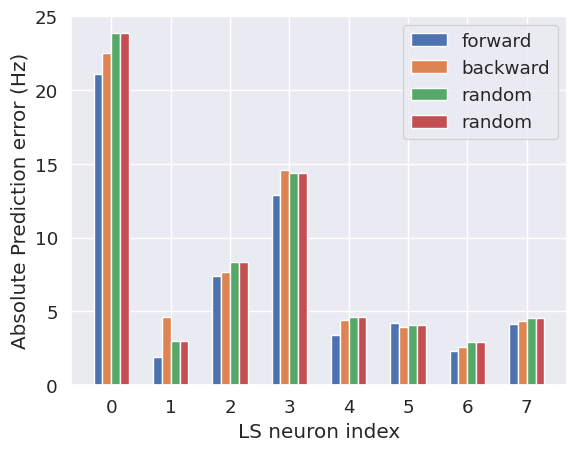

<BarContainer object of 8 artists>

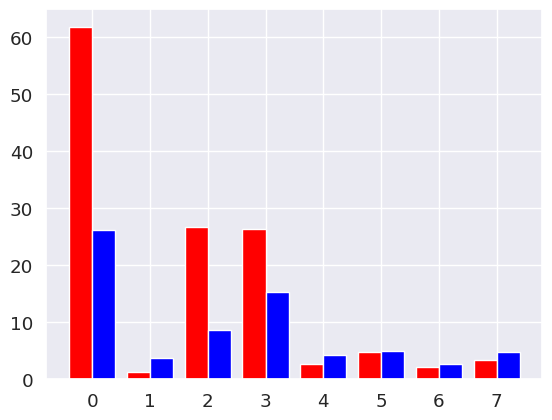

In [39]:
plt.figure()
plt.bar(np.arange(8) - 0.225, torch.sqrt(LS_test_pred_loss[forward_mse_idx, 0].sum(0)/len(forward_mse_idx)), width=0.15, label='forward')
plt.bar(np.arange(8) - 0.075, torch.sqrt(LS_test_pred_loss[backward_mse_idx, 0].sum(0)/len(backward_mse_idx)), width=0.15, label='backward')
plt.bar(np.arange(8) + 0.075, torch.sqrt(LS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.bar(np.arange(8) + 0.225, torch.sqrt(LS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.xlabel('LS neuron index')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

plt.figure()
plt.bar(np.arange(8) - 0.2, spks_stim_rates.mean(0)[mask1], color='red', width=0.4, label='LS')
plt.bar(np.arange(8) + 0.2, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), color='blue', width=0.4, label='LS')

Train GLM for LS neurons

In [11]:
from loguru import logger
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability


from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_LS_losses = np.zeros_like(Y_test_LS_np) # (499, 8)
output_dim = Y_test_LS_np.shape[1]

for i in range(output_dim):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses[:,i] += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    logger.info(f'Loss for LS neuron No {i}: {glm_LS_losses[:,i].sum() / Y_test_LS_np.shape[0]} (Hz^2).')
    logger.info(f'Forward: {glm_LS_losses[forward_mse_idx,i].sum() / len(forward_mse_idx)}, Backward: {glm_LS_losses[backward_mse_idx,i].sum() / len(backward_mse_idx)}, Random: {glm_LS_losses[random_mse_idx, i].sum() / len(random_mse_idx)}. Endogenous: {glm_LS_losses[non_stim_mse_idx, i].sum() / len(non_stim_mse_idx)}')

logger.info(f'Pred mean overall loss: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum() / np.prod(Y_test_LS_np.shape)}')
logger.info(f'GLM with identity function overall loss: {glm_LS_losses.sum() / np.prod(Y_test_LS.shape)}')

logger.info(f'GLM prediction for forward stim R2 loss: {glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for backward stim R2 loss: {glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for random stim R2 loss: {glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim}')
logger.info(f'GLM prediction for non-stim stim R2 loss: {glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim}')

2024-02-14 18:28:14.767 | INFO     | __main__:<module>:21 - Loss for LS neuron No 0: 903.3039203406813 (Hz^2).
2024-02-14 18:28:14.767 | INFO     | __main__:<module>:22 - Forward: 1028.0715625, Backward: 870.3731435643564, Random: 654.8308869949495. Endogenous: 980.932317839196
2024-02-14 18:28:40.471 | INFO     | __main__:<module>:21 - Loss for LS neuron No 1: 10.43661933241483 (Hz^2).
2024-02-14 18:28:40.473 | INFO     | __main__:<module>:22 - Forward: 2.4892926025390625, Backward: 21.722482209158414, Random: 9.929431029040405. Endogenous: 8.954568374097049
2024-02-14 18:29:07.744 | INFO     | __main__:<module>:21 - Loss for LS neuron No 2: 65.09991075901803 (Hz^2).
2024-02-14 18:29:07.744 | INFO     | __main__:<module>:22 - Forward: 54.728564453125, Backward: 66.2184405940594, Random: 71.40165325126263. Endogenous: 66.60892352386935
2024-02-14 18:29:36.538 | INFO     | __main__:<module>:21 - Loss for LS neuron No 3: 301.60564879759517 (Hz^2).
2024-02-14 18:29:36.540 | INFO     | __m

In [ ]:
logger.info(f'Predicting mean for each of the 8 LS neurons: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]}')

In [ ]:
plt.bar(np.arange(8)-0.2, np.sqrt(glm_LS_losses.mean(0)), width=0.1, label='overall')
plt.bar(np.arange(8)-0.1, np.sqrt(glm_LS_losses[forward_mse_idx].mean(0)), width=0.1, label='forward')
plt.bar(np.arange(8), np.sqrt(glm_LS_losses[backward_mse_idx].mean(0)), width=0.1, label='backward')
plt.bar(np.arange(8)+0.1, np.sqrt(glm_LS_losses[random_mse_idx].mean(0)), width=0.1, label='random')
plt.bar(np.arange(8)+0.2, np.sqrt(glm_LS_losses[non_stim_mse_idx].mean(0)), width=0.1, label='endogenous')
plt.show()

Train GLM for Others neurons

In [42]:
Y_train_nLS = Y_train[train_idx,:,:][..., nLS_neuron_idx]
Y_test_nLS = Y_test[..., nLS_neuron_idx]
Y_valid_nLS = Y_train[valid_idx,:,:][..., nLS_neuron_idx]

output_dim = len(nLS_neuron_idx)

batch_size = 1024
train_dataset = BNN_Dataset(X_train[train_idx, ...], Y_train_nLS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_nLS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)

valid_dataset = BNN_Dataset(X_train[valid_idx, ...], Y_valid_nLS)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

In [41]:
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_nLS_np = Y_train_nLS.cpu().numpy().reshape(Y_train_nLS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_nLS_np = Y_test_nLS.cpu().numpy().reshape(Y_test_nLS.shape[0],-1) + 1e-6 # numerical stability

output_dim = Y_test_nLS.shape[-1]

from tqdm import tqdm
from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_nLS_losses = np.zeros_like(Y_test_nLS_np)
output_dim = Y_test_nLS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_nLS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_nLS_reg.fit(X_train_np, Y_train_nLS_np[:,i])
    
    glm_nLS_losses[:,i] += np.power(Y_test_nLS_np[:,i] - glm_nLS_reg.predict(X_test_np), 2)

  0%|          | 0/98 [00:00<?, ?it/s]


ValueError: Found input variables with inconsistent numbers of samples: [5210, 4718]

In [43]:
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer
import gc

param_counts_nLS = []

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=valid_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)
    
    param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN)])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:55<00:00,  2.17it/s]


NameError: name 'param_counts' is not defined

In [16]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 6         | -149.4    | 820.7     | 971.4     | 2.254     | 14.15     |

d_model = 820
num_heads = 14
hidden_dim = 971
n_layers = 2

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model %2 != 0:
    d_model += num_heads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_nLS = TransformerDNN(input_dim=input_dim,
                    d_model=d_model,
                    num_heads=num_heads,
                    hidden_dim=hidden_dim,
                    output_dim=output_dim,
                    n_layers=n_layers,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)


assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

In [17]:
import wandb
wandb.login()
wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_nLS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=25, 
                                                       threshold=0.01)
num_epochs = 800

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_nLS,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=True,
            stim_type_indices=
            [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cngzlsh. Use `wandb login --relogin` to force relogin


100%|██████████| 800/800 [22:23<00:00,  1.68s/it]


In [18]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': output_dim,
                    'n_layers': n_layers,
                    'num_epochs': num_epochs},
        'train_data': return_dict}


with open(f'./data/biological/trained_models/EB095-stim-nLS-transformer-param.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./data/biological/trained_models/EB095-stim-nLS-transformer-param.pkl')

Saved model parameters and training stats to ./data/biological/trained_models/EB095-stim-nLS-transformer-param.pkl


In [19]:
# with open('./data/biological/trained_models/EB095-stim-LS-transformer-param.pkl', 'rb') as f:
    # data = pickle.load(f)
# return_dict = data['train_data']
DNN_nLS.load_state_dict(return_dict['best_eval_params'])

with torch.no_grad():
    Y_hat_nLS = DNN_nLS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    nLS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_nLS, Y_test[...,nLS_neuron_idx])
    print('Overall Transformer Loss:', nLS_test_pred_loss.sum()/np.prod(nLS_test_pred_loss.shape))
    print('Transformer prediction for forward stim MSE loss: ', nLS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(169.3231)
Transformer prediction for forward stim MSE loss:  tensor(152.9821)
Transformer prediction for backward stim MSE loss:  tensor(158.1711)
Transformer prediction for random stim MSE loss:  tensor(167.7341)
Transformer prediction for non-stim stim MSE loss:  tensor(183.9852)


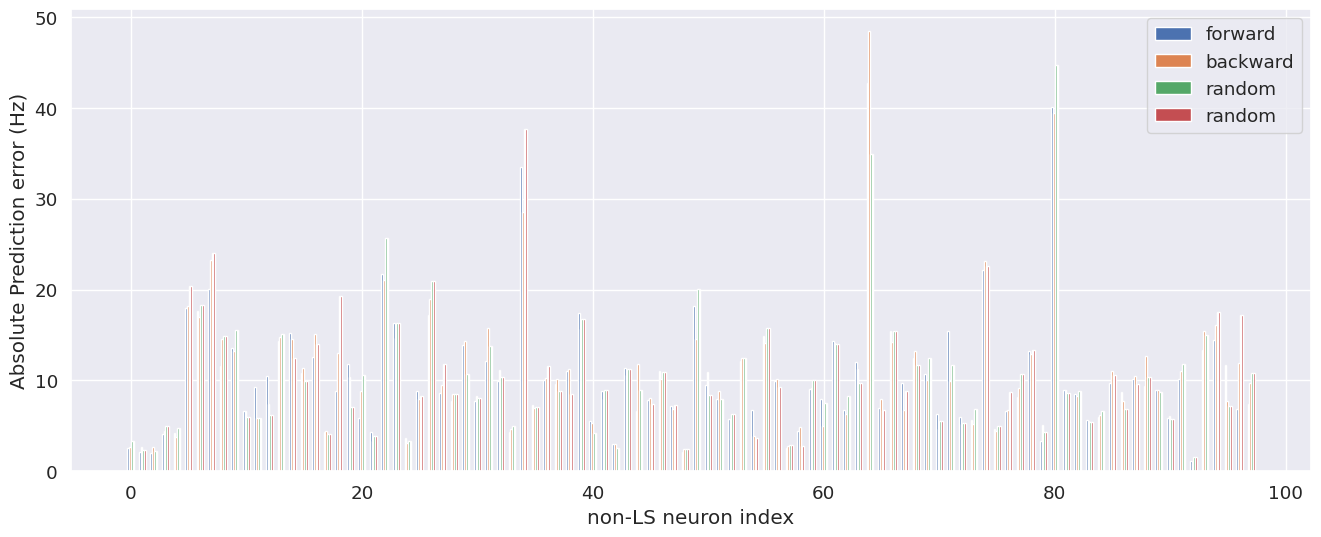

<BarContainer object of 98 artists>

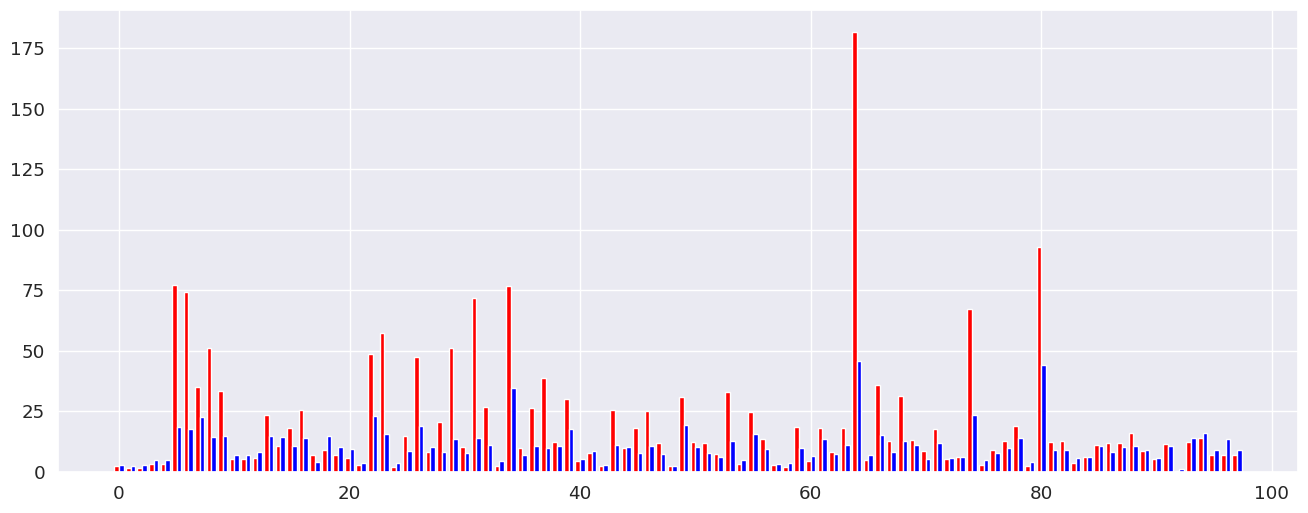

In [23]:
plt.figure(figsize=(16,6))
plt.bar(np.arange(output_dim) - 0.225, torch.sqrt(nLS_test_pred_loss[forward_mse_idx, 0].sum(0)/len(forward_mse_idx)), width=0.15, label='forward')
plt.bar(np.arange(output_dim) - 0.075, torch.sqrt(nLS_test_pred_loss[backward_mse_idx, 0].sum(0)/len(backward_mse_idx)), width=0.15, label='backward')
plt.bar(np.arange(output_dim) + 0.075, torch.sqrt(nLS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.bar(np.arange(output_dim) + 0.225, torch.sqrt(nLS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.xlabel('non-LS neuron index')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

plt.figure(figsize=(16,6))

plt.bar(np.arange(output_dim) - 0.2, spks_stim_rates.mean(0)[mask2], color='red', width=0.4, label='LS')
plt.bar(np.arange(output_dim) + 0.2, torch.sqrt(nLS_test_pred_loss.sum(0)[0]/nLS_test_pred_loss.shape[0]), color='blue', width=0.4, label='non-LS')